# First Preparing libraries and helper functions

In [163]:
import cv2, os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [164]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    t, img_bin = cv2.threshold(
        img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
    )
    return img_bin

In [165]:
def find_contours(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, h = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    return contours
    
def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)
    
def chain_hist(img_rgb):
    contours = find_contours(img_rgb)
    hists = []
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }
    for contour in contours:
        hist = np.zeros((8,))
        for i in range(len(contour)-1):
            pt1 = contour[i][0]
            pt2 = contour[i+1][0]
            dx = pt2[0] - pt1[0]
            dy = pt2[1] - pt1[1]
            code = lookup_table[(dx, dy)]
            hist[code] += 1
        hists.append(hist/hist.sum())

    return hists

In [167]:
# Checking the function
print(chain_hist(img)[0])

[0.15555556 0.08888889 0.17777778 0.08888889 0.13333333 0.08888889
 0.17777778 0.08888889]


In [168]:
# Now getting the data to train a model
def create_df(data_path):
    
    # the class_dict is a mapping between class name and value
    class_dict = {
        'circle': 0,
        'square': 1,
        'star': 2,
        'triangle': 3
    }
    
    # we store image paths and outputs here
    df = []
    
    # for each class
    for class_name, class_value in class_dict.items():
        class_folder = os.path.join(data_path, class_name)
        # for each image in class folder
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            # if this is a "png" file, add its path and output
            if f_path.lower().endswith('.png'):
                df.append([f_path, class_value])
    
    # create a dataframe of image paths and outputs
    df = pd.DataFrame(df, columns=['path', 'output'])
    
    return df

In [169]:
data = create_df('shapes/shapes/')
data

,path,output
0,shapes/shapes/circle\0.png,0
1,shapes/shapes/circle\1.png,0
2,shapes/shapes/circle\10.png,0
3,shapes/shapes/circle\100.png,0
4,shapes/shapes/circle\1000.png,0
...,...,...
14965,shapes/shapes/triangle\995.png,3
14966,shapes/shapes/triangle\996.png,3
14967,shapes/shapes/triangle\997.png,3
14968,shapes/shapes/triangle\998.png,3


In [11]:
from tqdm import tqdm

def extract_features(img_paths):
    n = len(img_paths)
    X = np.zeros((n, 8))
    for i in tqdm(range(n)):
        f_path = img_paths[i]
        img = imread(f_path)
        features = chain_hist(img)
        X[i] = features
    return X

In [12]:
X = extract_features(data['path'])

100%|███████████████████████████████████████████████████████████████████████████| 14970/14970 [00:18<00:00, 821.82it/s]


In [13]:
y = data['output']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0
)

In [16]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [17]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9370168909247065
0.9423291026497439


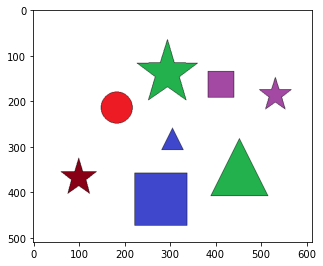

In [171]:
img = imread('images/shapes.png')
imshow(img)

In [173]:
shapes = chain_hist(img)
result = []
classes = ['circle', 'square', 'star', 'triangle']
for shape in shapes:
    y = model.predict([shape])[0]
    result.append(classes[y])
result   

['square', 'star', 'triangle', 'triangle', 'square', 'star', 'square', 'star']

In [174]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
t, img_shapes_bin = cv2.threshold(
    img_gray,
    0,
    255,
    cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
)
components = cv2.connectedComponentsWithStats(
    img_shapes_bin, connectivity=4)

(nLabels, labels, stats, centroids) = components

centroids = centroids.astype(int)

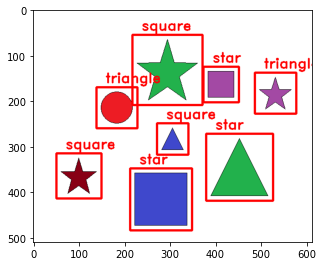

In [175]:
# copy image to avoid drawing on the original image
img = img.copy()
j = 0
for i in range(1, nLabels):
    x, y, w, h, area = stats[i]
    
    acceptWidth = (w > 40 and w < 150)
    acceptHeight = (h > 40 and h < 150)

    if acceptWidth and acceptHeight:
        cv2.rectangle(img, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)
        cv2.putText(img, result[j], 
                org = (x+10, y-20), 
                fontFace = cv2.FONT_HERSHEY_DUPLEX, 
                fontScale = 1.0, color = (255, 0, 0),
                thickness = 2)
        j += 1
# show image with locations of detected components
imshow(img)

In [178]:
# After Sorting results manually
result2 = ['Star', 'Square', 'Star', 'Circle', 'Triangle', 'Triangle', 'Star', 'Square']

In [179]:
# Using th same code to check after sorting
img = imread('images/shapes.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
t, img_shapes_bin = cv2.threshold(
    img_gray,
    0,
    255,
    cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
)
components = cv2.connectedComponentsWithStats(
    img_shapes_bin, connectivity=4)

(nLabels, labels, stats, centroids) = components

centroids = centroids.astype(int)

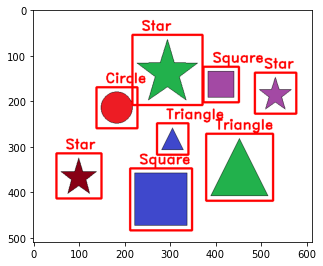

In [180]:
# copy image to avoid drawing on the original image
img = img.copy()
j = 0
for i in range(1, nLabels):
    x, y, w, h, area = stats[i]
    
    acceptWidth = (w > 40 and w < 150)
    acceptHeight = (h > 40 and h < 150)

    if acceptWidth and acceptHeight:
        cv2.rectangle(img, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)
        cv2.putText(img, result2[j], 
                org = (x+10, y-20), 
                fontFace = cv2.FONT_HERSHEY_DUPLEX, 
                fontScale = 1.0, color = (255, 0, 0),
                thickness = 2)
        j += 1
# show image with locations of detected components
imshow(img)